In [1]:
%load_ext lab_black
import os, sys

%load_ext autoreload
%autoreload 2

sys.path.append("/n/home12/khou/holystore/")

import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import paper_utils
import matplotlib.pyplot as plt
import scdrs.data_loader as dl
import pandas as pd
import numpy as np
from os.path import join
from statsmodels.stats.multitest import multipletests
from scipy.stats import rankdata
from tqdm import tqdm
from scipy import stats
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

In [2]:
def small_squares(ax, pos, size=1, linewidth=0.8):
    """
    Draw many small squares on ax, given the positions of
    these squares.

    """
    for xy in pos:
        x, y = xy
        margin = (1 - size) / 2
        rect = patches.Rectangle(
            (x + margin, y + margin),
            size,
            size,
            linewidth=linewidth,
            edgecolor="k",
            facecolor="none",
            zorder=20,
        )
        ax.add_patch(rect)


def celltype_display_name(x):
    if x in dict_celltype_name:
        name = dict_celltype_name[x]
    else:
        name = x
    name += f" ({df_celltype_n_cell[x]})"
    name = name.replace("_", " ")
    name = name[0].upper() + name[1:]
    return name


def trait_display_name(x):
    dict_trait_name = {
        row.Trait_Identifier: row["Trait Name"] for _, row in df_trait_info.iterrows()
    }
    dict_trait_code = {
        row.Trait_Identifier: row["Code"] for _, row in df_trait_info.iterrows()
    }

    if dict_trait_name[x].lower() != dict_trait_code[x].lower():
        return f"{dict_trait_name[x]} ({dict_trait_code[x]})"
    else:
        return dict_trait_name[x]


def asterisk_display(x):
    if x < 0.05:
        return "×"
    else:
        return ""

In [3]:
# Setup file paths
DATA_PATH = "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data"
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name="facs")
df_hom = pd.read_csv(
    "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/"
    "mouse_human_homologs.txt",
    sep="\t",
)

SCORE_PATH = join(
    DATA_PATH, "score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore"
)
URL_SUPP_TABLE = "https://www.dropbox.com/s/k4tkz981t4x1km5/supp-tables.xlsx?dl=1"

df_trait_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=0,
)

df_celltype_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=1,
)

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


In [4]:
df_tmp = pd.read_csv(
    "/n/holystore01/LABS/price_lab/Users/khou/scDRS-public/experiments/job.celltype_association/data/summary_ct/drs_fdr_prop.10kb.1000.csv",
    index_col=0,
)
trait_order = df_tmp.index.tolist()
ct_order = df_tmp.columns

trait_order[
    np.where(df_tmp.index == "PASS_BIP_Stahl2019")[0].item()
] = "PASS_BIP_Mullins2021"

# Compare two BIP results

In [5]:
df_score_2019 = pd.read_csv(
    os.path.join(SCORE_PATH, "PASS_BIP_Stahl2019.score.gz"), sep="\t"
)
df_score_2021 = pd.read_csv(
    os.path.join(SCORE_PATH, "PASS_BIP_Mullins2021.score.gz"), sep="\t"
)
v_fdr = multipletests(df_score_2019["pval"].values, method="fdr_bh")[1]
n_2019 = (v_fdr < 0.1).sum()

v_fdr = multipletests(df_score_2021["pval"].values, method="fdr_bh")[1]
n_2021 = (v_fdr < 0.1).sum()

print(
    f"Number of discoveries for two bipolar sumstats, BIP 2019: {n_2019}, BIP 2021: {n_2021}"
)

Number of discoveries for two bipolar sumstats, BIP 2019: 104, BIP 2021: 655


In [6]:
df_fdr_prop = pd.read_csv("data/summary_ct/drs_fdr_prop.tms_facs.csv", index_col=0).loc[
    trait_order, ct_order
]

df_gearysc_meta_fdr = pd.read_csv(
    "data/summary_ct/df_gearysc_fdr.tms_facs.csv", index_col=0
)

# Overview

In [7]:
df_ct_pval = pd.read_csv("data/summary_ct/df_pval.tms_facs.csv", index_col=0)
df_ct_fdr = pd.DataFrame(
    multipletests(df_ct_pval.values.flatten(), method="fdr_bh")[1].reshape(
        df_ct_pval.shape
    ),
    index=df_ct_pval.index,
    columns=df_ct_pval.columns,
)

In [8]:
fev1fvc_fdr = df_ct_fdr.loc["UKB_460K.lung_FEV1FVCzSMOKE"].sort_values()
print("Number of significant cell types for FEV1/FVC: ", np.sum(fev1fvc_fdr < 0.05))
display(fev1fvc_fdr[fev1fvc_fdr < 0.05])

Number of significant cell types for FEV1/FVC:  20


fibroblast                           0.019285
pulmonary_interstitial_fibroblast    0.019285
brain_pericyte                       0.019285
chondrocyte                          0.019285
basal_cell                           0.019285
pancreatic_stellate_cell             0.019285
mesenchymal_stem_cell_of_adipose     0.019285
mesenchymal_stem_cell                0.019285
bladder_cell                         0.019285
adventitial_cell                     0.019285
smooth_muscle_cell                   0.019285
fibroblast_of_lung                   0.019285
smooth_muscle_cell_of_trachea        0.019285
stromal_cell                         0.019285
type_II_pneumocyte                   0.019285
fibroblast_of_cardiac_tissue         0.019285
pericyte_cell                        0.019285
valve_cell                           0.032436
mesangial_cell                       0.044579
bulge_keratinocyte                   0.044579
Name: UKB_460K.lung_FEV1FVCzSMOKE, dtype: float64

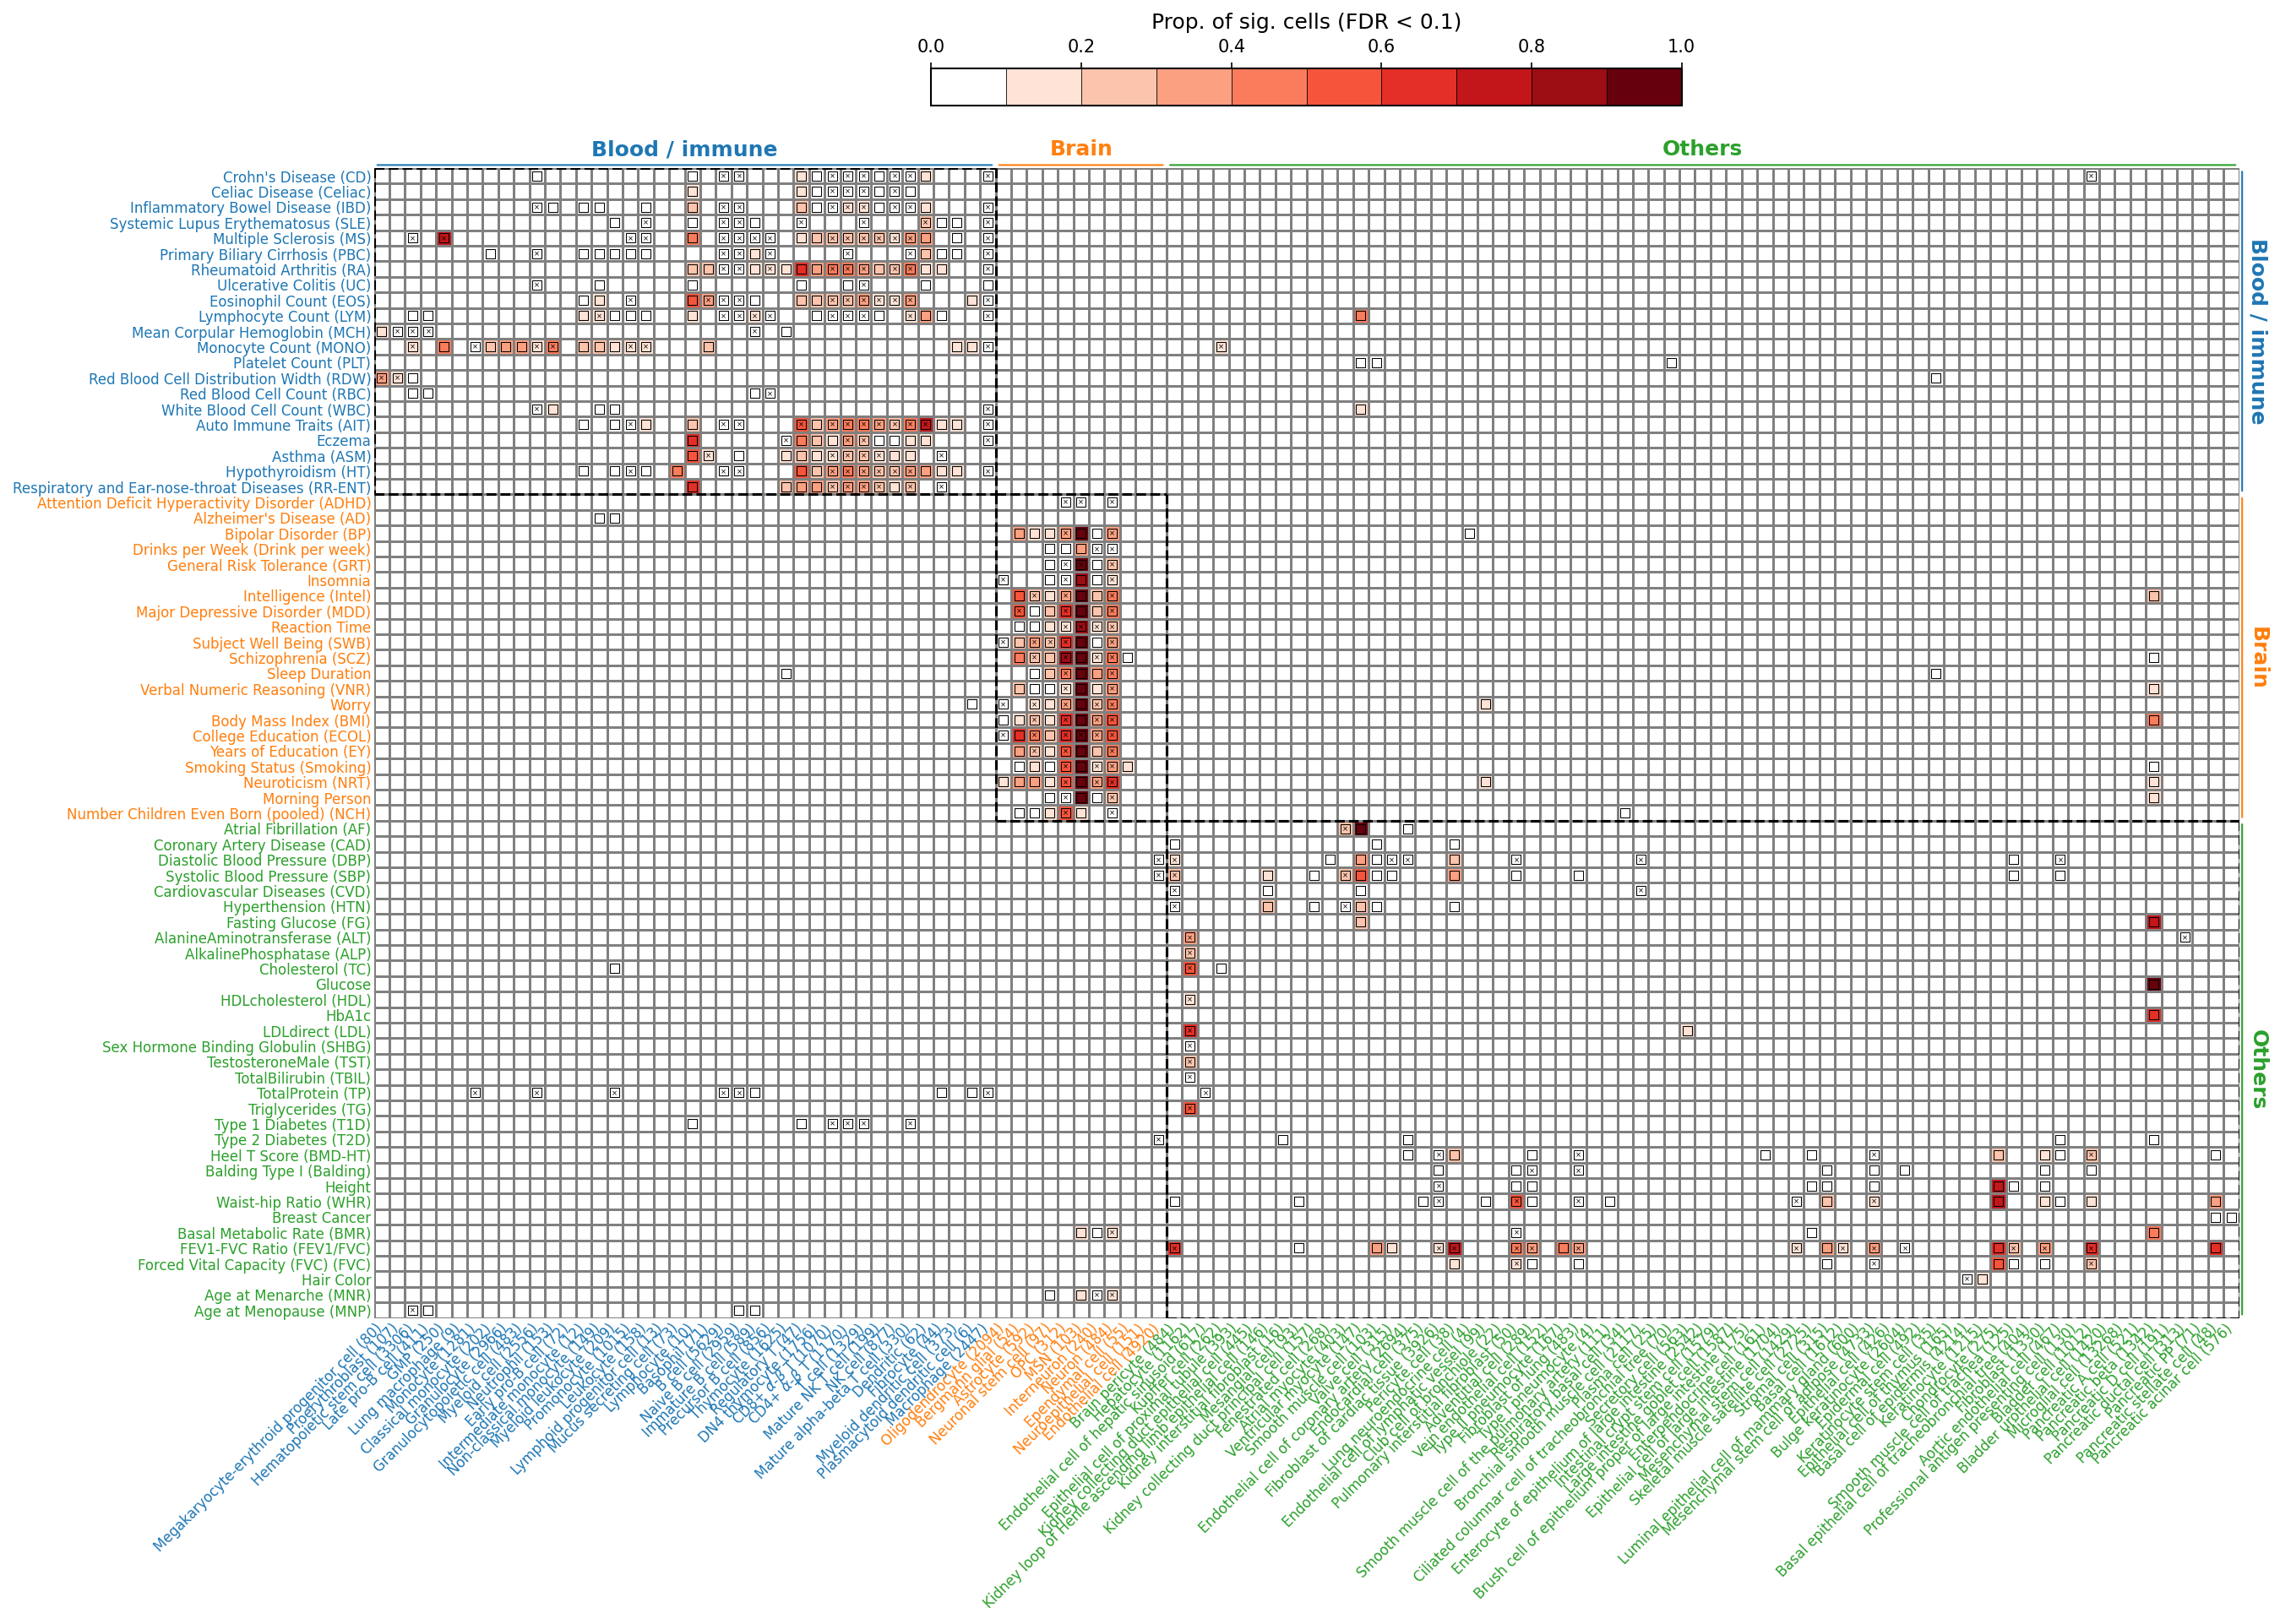

In [9]:
df_celltype_n_cell = data_facs_ct.obs.cell_ontology_class.value_counts()
df_celltype_n_cell.index = [
    c.replace(" ", "_").replace(",", "") for c in df_celltype_n_cell.index
]


dict_celltype_name = {
    row.id: row.code for _, row in df_celltype_info.iterrows() if not pd.isna(row.code)
}

df_plot = df_fdr_prop.copy()

df_ct_pval = pd.read_csv("data/summary_ct/df_pval.tms_facs.csv", index_col=0)
df_ct_fdr = pd.DataFrame(
    multipletests(df_ct_pval.values.flatten(), method="fdr_bh")[1].reshape(
        df_ct_pval.shape
    ),
    index=df_ct_pval.index,
    columns=df_ct_pval.columns,
)
df_ct_fdr = df_ct_fdr.loc[df_plot.index, df_plot.columns].copy()

df_gearysc_plot = df_gearysc_meta_fdr.loc[df_plot.index, df_plot.columns].copy()

df_gearysc_annot = df_gearysc_plot.applymap(asterisk_display)
df_gearysc_annot[df_ct_fdr > 0.05] = ""
df_plot[df_ct_fdr > 0.05] = 0.0

df_plot = df_plot.rename(index=trait_display_name, columns=celltype_display_name)

fig, ax = paper_utils.plot_heatmap(
    df_plot,
    squaresize=20,
    heatmap_annot=df_gearysc_annot,
    heatmap_annot_kws={"color": "black", "size": 4},
    heatmap_cbar_kws=dict(
        use_gridspec=False, location="top", fraction=0.03, pad=0.05, drawedges=True
    ),
    heatmap_vmin=0,
    heatmap_vmax=1,
    colormap_n_bin=10,
)

######### add small squares to show cell-type trait association ##########

small_squares(
    ax,
    pos=[(y, x) for x, y in zip(*np.where(df_ct_fdr < 0.05))],
    size=0.6,
    linewidth=0.5,
)

cb = ax.collections[0].colorbar
cb.ax.set_title("Prop. of sig. cells (FDR < 0.1)")
cb.outline.set_edgecolor("black")
cb.outline.set_linewidth(1)

# add diagonal boxes

x_seps = [
    df_trait_info.Category.isin(["blood/immune"]).sum(),
    df_trait_info.Category.isin(["brain"]).sum(),
    df_trait_info.Category.isin(["metabolic", "heart", "other"]).sum(),
]
y_seps = [
    df_celltype_info.category.isin(["blood", "immune"]).sum(),
    df_celltype_info.category.isin(["brain"]).sum(),
    df_celltype_info.category.isin(["others"]).sum(),
]
paper_utils.plot_diagonal_block(y_seps, x_seps, ax, linewidth=1.5)


dict_group_colors = {"Blood / immune": "C0", "Brain": "C1", "Others": "C2"}
# annotate cell-types
ct_breaks = np.cumsum([0] + y_seps)
for i, ct in enumerate(["Blood / immune", "Brain", "Others"]):
    paper_utils.annotation_line(
        ax=ax,
        text=ct,
        xy1=(ct_breaks[i], -0.2),
        xy2=(ct_breaks[i + 1], -0.2),
        text_offset_y=-1,
        linecolor=dict_group_colors[ct],
        text_color=dict_group_colors[ct],
        fontsize=12,
    )
    for label in ax.xaxis.get_ticklabels()[ct_breaks[i] : ct_breaks[i + 1]]:
        label.set_color(dict_group_colors[ct])

# annotate traits
trait_breaks = np.cumsum([0] + x_seps)
for i, trait in enumerate(["Blood / immune", "Brain", "Others"]):

    paper_utils.annotation_line(
        ax=ax,
        text=trait,
        xy1=(ct_breaks[-1] + 0.2, trait_breaks[i]),
        xy2=(ct_breaks[-1] + 0.2, trait_breaks[i + 1]),
        text_rotation=270,
        text_offset_x=1,
        linecolor=dict_group_colors[trait],
        text_color=dict_group_colors[trait],
        fontsize=12,
    )
    for label in ax.yaxis.get_ticklabels()[trait_breaks[i] : trait_breaks[i + 1]]:
        label.set_color(dict_group_colors[trait])


plt.savefig("results/celltype_assoc_detail.pdf", bbox_inches="tight")
plt.show()

In [10]:
print(
    f"Out of all {df_ct_fdr.shape[0] * df_ct_fdr.shape[1]} cell type disease pairs, {(df_ct_fdr <= 0.05).sum().sum()} significant, {(df_gearysc_annot == '×').sum().sum()} heterogenous"
)

print(
    f"{((df_ct_fdr < 0.05) & (df_gearysc_annot == '×')).any(axis=1).sum()} out of {(df_ct_fdr < 0.05).any(axis=1).sum()} traits with a critical cell type has a significant heterogeneity cell-type"
)

Out of all 8880 cell type disease pairs, 597 significant, 273 heterogenous
67 out of 74 traits with a critical cell type has a significant heterogeneity cell-type


In [11]:
for trait_cat, ct_cat in zip(
    [["blood/immune"], ["brain"], ["metabolic", "heart", "other"]],
    [["blood", "immune"], ["brain"], ["others"]],
):
    df_gearysc_annot_cat = df_gearysc_annot.loc[
        df_trait_info.Category.isin(trait_cat).values,
        df_celltype_info.category.isin(ct_cat).values,
    ]
    df_ct_fdr_cat = df_ct_fdr.loc[
        df_trait_info.Category.isin(trait_cat).values,
        df_celltype_info.category.isin(ct_cat).values,
    ]
    print(
        f"{trait_cat}: number of  cell types: {df_ct_fdr_cat.shape[1]}, number of traits: {df_ct_fdr_cat.shape[0]}"
    )
    print(
        f"Number of significant cell type trait pair: {(df_ct_fdr_cat < 0.05).sum().sum()} / {df_ct_fdr_cat.shape[0] * df_ct_fdr_cat.shape[1]}"
    )

    print(
        f"Number of significant heterogeneity cell type trait pair: {(df_gearysc_annot_cat == '×').sum().sum()} / {df_gearysc_annot_cat.shape[0] * df_gearysc_annot_cat.shape[1]}"
    )

['blood/immune']: number of  cell types: 40, number of traits: 21
Number of significant cell type trait pair: 264 / 840
Number of significant heterogeneity cell type trait pair: 136 / 840
['brain']: number of  cell types: 11, number of traits: 21
Number of significant cell type trait pair: 133 / 231
Number of significant heterogeneity cell type trait pair: 64 / 231
['metabolic', 'heart', 'other']: number of  cell types: 69, number of traits: 32
Number of significant cell type trait pair: 146 / 2208
Number of significant heterogeneity cell type trait pair: 54 / 2208


In [12]:
df_ct_fdr_brain = df_ct_fdr.loc[
    df_trait_info.Trait_Identifier[df_trait_info.Category.isin(["brain"])],
    df_celltype_info.id[df_celltype_info.category.isin(["brain"])],
]
print(
    f"Number of brain cell types: {df_ct_fdr_brain.shape[1]}, number of brain traits: {df_ct_fdr_brain.shape[0]}"
)
print(
    f"Number of significant cell type trait pair: {(df_ct_fdr_brain < 0.05).sum().sum()}"
)

Number of brain cell types: 11, number of brain traits: 21
Number of significant cell type trait pair: 133


# Main figures

In [28]:
# Plot order for main figure
df_tmp = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name="fig3-display",
).dropna(how="all")
# df_tmp.loc[17, "celltype"] = np.nan
# df_tmp.dropna(how="all")
plot_order = dict()
for c, group in df_tmp.groupby("cluster"):
    plot_order[c] = (group.trait.dropna().values, group.celltype.dropna().values)

dict_trait_name = {
    row.Trait_Identifier: row["Code"] for _, row in df_trait_info.iterrows()
}

dict_celltype_name = {
    row.id: row.code for _, row in df_celltype_info.iterrows() if not pd.isna(row.code)
}


def trait_display_name(x):
    dict_trait_name = {
        row.Trait_Identifier: row["Trait Name"] for _, row in df_trait_info.iterrows()
    }
    dict_trait_code = {
        row.Trait_Identifier: row["Code"] for _, row in df_trait_info.iterrows()
    }

    if dict_trait_name[x].lower() != dict_trait_code[x].lower():
        display_name = f"{dict_trait_name[x]} ({dict_trait_code[x]})"
    else:
        display_name = dict_trait_name[x]

    # special case for RDW
    if dict_trait_code[x] == "RDW":
        return "RBC Distribution width (RDW)"
    return display_name

In [29]:
df_ct_pval = pd.read_csv("data/summary_ct/df_pval.tms_facs.csv", index_col=0)
df_ct_fdr = pd.DataFrame(
    multipletests(df_ct_pval.values.flatten(), method="fdr_bh")[1].reshape(
        df_ct_pval.shape
    ),
    index=df_ct_pval.index,
    columns=df_ct_pval.columns,
)

df_ct_fdr = df_ct_fdr.loc[
    np.concatenate([plot_order[c][0] for c in plot_order]),
    np.concatenate([plot_order[c][1] for c in plot_order]),
]


df_plot = df_fdr_prop.loc[
    np.concatenate([plot_order[c][0] for c in plot_order]),
    np.concatenate([plot_order[c][1] for c in plot_order]),
].copy()
print("Number of traits / cell types in the analysis:", df_plot.shape)
# add diagonal boxes
x_seps = [len(plot_order[c][0]) for c in plot_order]
y_seps = [len(plot_order[c][1]) for c in plot_order]

df_gearysc_plot = df_gearysc_meta_fdr.loc[df_plot.index, df_plot.columns].copy()

df_gearysc_annot = df_gearysc_plot.applymap(asterisk_display)
# df_gearysc_annot[(df_ct_fdr > 0.05)] = ""
# df_plot[df_ct_fdr > 0.05] = 0.0

Number of traits / cell types in the analysis: (22, 19)


In [30]:
print("heatmap colors omitted for:")

row_idx, col_idx = np.where((df_plot > 0.1) & (df_ct_fdr > 0.05))
for r, c in zip(row_idx, col_idx):
    print(df_plot.index[r], df_plot.columns[c])

print("\ncross symbols omitted for:")

row_idx, col_idx = np.where((df_gearysc_annot == "×") & (df_ct_fdr > 0.05))
for r, c in zip(row_idx, col_idx):
    print(df_gearysc_annot.index[r], df_gearysc_annot.columns[c])

heatmap colors omitted for:
UKB_460K.disease_ASTHMA_DIAGNOSED dendritic_cell

cross symbols omitted for:
UKB_460K.blood_MONOCYTE_COUNT CD4-positive_alpha-beta_T_cell
UKB_460K.blood_MONOCYTE_COUNT CD8-positive_alpha-beta_T_cell
PASS_Rheumatoid_Arthritis bladder_cell
UKB_460K.disease_ASTHMA_DIAGNOSED bladder_cell
PASS_BIP_Mullins2021 oligodendrocyte
UKB_460K.bmd_HEEL_TSCOREz dendritic_cell


Number of traits / cell types in the analysis: (22, 19)
43 of 80 associations are heterogeneous


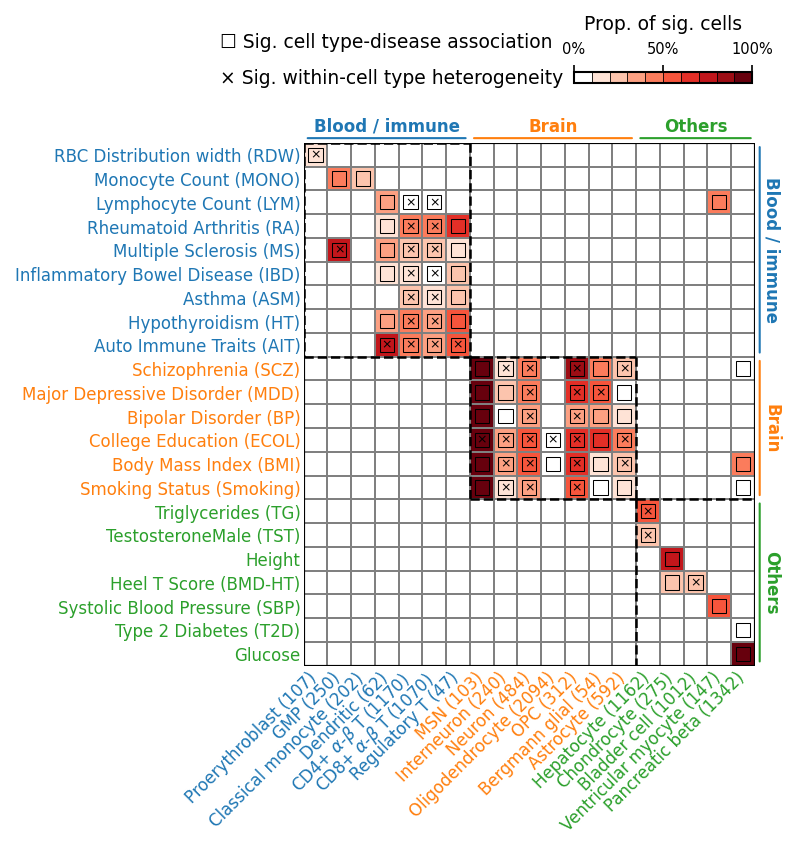

In [31]:
df_ct_pval = pd.read_csv("data/summary_ct/df_pval.tms_facs.csv", index_col=0)
df_ct_fdr = pd.DataFrame(
    multipletests(df_ct_pval.values.flatten(), method="fdr_bh")[1].reshape(
        df_ct_pval.shape
    ),
    index=df_ct_pval.index,
    columns=df_ct_pval.columns,
)

df_ct_fdr = df_ct_fdr.loc[
    np.concatenate([plot_order[c][0] for c in plot_order]),
    np.concatenate([plot_order[c][1] for c in plot_order]),
]


df_plot = df_fdr_prop.loc[
    np.concatenate([plot_order[c][0] for c in plot_order]),
    np.concatenate([plot_order[c][1] for c in plot_order]),
].copy()
print("Number of traits / cell types in the analysis:", df_plot.shape)
# add diagonal boxes
x_seps = [len(plot_order[c][0]) for c in plot_order]
y_seps = [len(plot_order[c][1]) for c in plot_order]

df_gearysc_plot = df_gearysc_meta_fdr.loc[df_plot.index, df_plot.columns].copy()

df_gearysc_annot = df_gearysc_plot.applymap(asterisk_display)
df_gearysc_annot[(df_ct_fdr > 0.05)] = ""

df_plot[df_ct_fdr > 0.05] = 0.0
df_plot = df_plot.rename(index=trait_display_name, columns=celltype_display_name)

print(
    f"{np.sum(df_gearysc_annot == '×').sum()} of {np.sum(df_ct_fdr <= 0.05).sum()} associations are heterogeneous"
)

fig, ax = paper_utils.plot_heatmap(
    df_plot,
    squaresize=27,
    heatmap_annot=df_gearysc_annot,
    heatmap_annot_kws={"color": "black", "size": 6},
    heatmap_xticklabels=True,
    heatmap_yticklabels=True,
    heatmap_linecolor="gray",
    heatmap_linewidths=0.05,
    heatmap_cbar_kws=dict(
        use_gridspec=False,
        location="top",
        fraction=0.02,
        pad=0.1,
        drawedges=True,
        anchor=(0.9, 1.0),
        aspect=15,
    ),
    heatmap_vmin=0,
    heatmap_vmax=1.0,
    colormap_n_bin=10,
)

small_squares(
    ax,
    pos=[(y, x) for x, y in zip(*np.where(df_ct_fdr < 0.05))],
    size=0.6,
    linewidth=0.5,
)
cb = ax.collections[0].colorbar
cb.outline.set_edgecolor("black")
cb.outline.set_linewidth(1)
cb.ax.set_title("Prop. of sig. cells", fontsize=9)
cb.set_ticks([0, 0.5, 1.0])
cb.ax.set_xticklabels(["0%", "50%", "100%"], size=7)
# add bounding box

for x in ax.get_xlim():
    ax.axvline(x=x, color="k", linewidth=1)
    ax.axvline(x=x, color="k", linewidth=1)

for y in ax.get_ylim():
    ax.axhline(y=y, color="k", linewidth=1)
    ax.axhline(y=y, color="k", linewidth=1)


paper_utils.plot_diagonal_block(y_seps, x_seps, ax, linewidth=1.2)

dict_group_colors = {"Blood / immune": "C0", "Brain": "C1", "Others": "C2"}
# annotate cell-types
ct_breaks = np.cumsum([0] + y_seps)
for i, ct in enumerate(["Blood / immune", "Brain", "Others"]):
    paper_utils.annotation_line(
        ax=ax,
        text=ct,
        xy1=(ct_breaks[i], -0.2),
        xy2=(ct_breaks[i + 1], -0.2),
        text_offset_y=-0.5,
        linecolor=dict_group_colors[ct],
        text_color=dict_group_colors[ct],
    )
    for label in ax.xaxis.get_ticklabels()[ct_breaks[i] : ct_breaks[i + 1]]:
        label.set_color(dict_group_colors[ct])

# annotate traits
trait_breaks = np.cumsum([0] + x_seps)
for i, trait in enumerate(["Blood / immune", "Brain", "Others"]):

    paper_utils.annotation_line(
        ax=ax,
        text=trait,
        xy1=(ct_breaks[-1] + 0.2, trait_breaks[i]),
        xy2=(ct_breaks[-1] + 0.2, trait_breaks[i + 1]),
        text_rotation=270,
        text_offset_x=0.5,
        linecolor=dict_group_colors[trait],
        text_color=dict_group_colors[trait],
    )
    for label in ax.yaxis.get_ticklabels()[trait_breaks[i] : trait_breaks[i + 1]]:
        label.set_color(dict_group_colors[trait])

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.text(-3.5, -4, "☐ Sig. cell type-disease association", fontsize=9)
plt.text(-3.5, -2.5, "× Sig. within-cell type heterogeneity", fontsize=9)


plt.savefig("results/celltype_assoc_overview.pdf", bbox_inches="tight")

In [32]:
df_ct_pval1 = pd.read_csv("data/summary_ct/df_pval.tms_facs.csv", index_col=0)
df_fdr_prop1 = pd.read_csv("data/summary_ct/drs_fdr_prop.tms_facs.csv", index_col=0)

df_ct_fdr1 = pd.DataFrame(
    multipletests(df_ct_pval1.values.flatten(), method="fdr_bh")[1].reshape(
        df_ct_pval1.shape
    ),
    index=df_ct_pval1.index,
    columns=df_ct_pval1.columns,
)

OLD_DIR = "../../../scDRS-public/experiments/job.celltype_association/data/summary_ct/"
df_ct_pval2 = pd.read_csv(
    f"{OLD_DIR}/df_pval.tms_facs.csv",
    index_col=0,
)
df_fdr_prop2 = pd.read_csv(f"{OLD_DIR}/drs_fdr_prop.tms_facs.csv", index_col=0)
df_ct_fdr2 = pd.DataFrame(
    multipletests(df_ct_pval2.values.flatten(), method="fdr_bh")[1].reshape(
        df_ct_pval2.shape
    ),
    index=df_ct_pval2.index,
    columns=df_ct_pval2.columns,
)

In [33]:
# Plot order for main figure
df_tmp = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name="fig3-display",
).dropna(how="all")
trait_list1 = df_tmp["trait"].dropna().values
ct_list1 = df_tmp["celltype"].dropna().values

In [34]:
df_tmp = pd.read_excel(
    "https://www.dropbox.com/s/378cmb4vg06ssai/supp_tables.082821.xlsx?dl=1",
    sheet_name="fig3-display",
).dropna(how="all")
trait_list2 = df_tmp["trait"].dropna().values
ct_list2 = list(set(df_tmp["celltype"].dropna().values) - set(["Bergmann_glial_cell"]))

In [35]:
print(
    f"Total #sig in new: {(df_ct_fdr1.loc[trait_list1, ct_list1] < 0.05).sum().sum()}"
)
for t in trait_list1:
    for c in ct_list1:
        if df_ct_fdr1.loc[t, c] < 0.05:
            if (t in trait_list2) & (c in ct_list2):
                if df_ct_fdr2.loc[t, c] > 0.05:
                    print(
                        c,
                        t,
                        f"new: {df_ct_fdr1.loc[t, c]:.2g}, old: {df_ct_fdr2.loc[t, c]:.2g}",
                    )

Total #sig in new: 80
granulocyte_monocyte_progenitor_cell UKB_460K.blood_MONOCYTE_COUNT new: 0.045, old: 0.057
dendritic_cell PASS_Rheumatoid_Arthritis new: 0.019, old: 0.067
dendritic_cell PASS_Multiple_sclerosis new: 0.032, old: 0.077
oligodendrocyte UKB_460K.body_BMIz new: 0.045, old: 0.057
pancreatic_B_cell UKB_460K.cov_SMOKING_STATUS new: 0.032, old: 0.1


In [36]:
print(
    f"Total #sig in old: {(df_ct_fdr2.loc[trait_list2, ct_list2] < 0.05).sum().sum()}"
)

for t in trait_list2:
    for c in ct_list2:
        if df_ct_fdr2.loc[t, c] < 0.05:
            if df_ct_fdr1.loc[t, c] > 0.05:
                print(
                    c,
                    t,
                    f"new: {df_ct_fdr1.loc[t, c]:.2g}, old: {df_ct_fdr2.loc[t, c]:.2g}",
                )

Total #sig in old: 70
hepatocyte UKB_460K.blood_RBC_DISTRIB_WIDTH new: 0.074, old: 0.046
classical_monocyte PASS_IBD_deLange2017 new: 0.054, old: 0.02
dendritic_cell UKB_460K.disease_ASTHMA_DIAGNOSED new: 0.11, old: 0.02
oligodendrocyte PASS_MDD_Howard2019 new: 0.064, old: 0.046
pancreatic_PP_cell UKB_460K.bmd_HEEL_TSCOREz new: 0.064, old: 0.046


In [ ]:
pairs = [
    ("UKB_460K.blood_MONOCYTE_COUNT", "granulocyte_monocyte_progenitor_cell"),
    ("PASS_Rheumatoid_Arthritis", "dendritic_cell"),
    ("PASS_Multiple_sclerosis", "dendritic_cell"),
    ("UKB_460K.bmd_HEEL_TSCOREz", "pancreatic_PP_cell"),
    ("UKB_460K.blood_RBC_DISTRIB_WIDTH", "hepatocyte"),
]

In [ ]:
for p in pairs:
    print(
        f"({p[0]}, {p[1]}): new FDR={df_ct_fdr1.loc[p[0], p[1]]:.2g}, old FDR={df_ct_fdr2.loc[p[0], p[1]]:.2g}"
    )

# Plotting cell-type p-values below

In [ ]:
df_ct_pval = pd.read_csv("data/summary_ct/df_pval.tms_facs.csv", index_col=0)
df_plot_fdr = pd.DataFrame(
    multipletests(df_ct_pval.values.flatten(), method="fdr_bh")[1].reshape(
        df_ct_pval.shape
    ),
    index=df_ct_pval.index,
    columns=df_ct_pval.columns,
)

df_plot = df_ct_pval.loc[
    np.concatenate([plot_order[c][0] for c in plot_order]),
    np.concatenate([plot_order[c][1] for c in plot_order]),
].copy()

df_plot_fdr = df_plot_fdr.loc[df_plot.index, df_plot.columns]
df_plot_fdr = df_plot_fdr.rename(index=trait_display_name)


def signif_display(x):
    if x < 0.05:
        return "*"
    else:
        return ""


df_plot_annot = df_plot_fdr.applymap(signif_display)
df_plot = -np.log10(df_plot)
df_plot = df_plot.rename(index=trait_display_name, columns=celltype_display_name)


print("Number of traits / cell types in the analysis:", df_plot.shape)
# add diagonal boxes
x_seps = [len(plot_order[c][0]) for c in plot_order]
y_seps = [len(plot_order[c][1]) for c in plot_order]


fig, ax = paper_utils.plot_heatmap(
    df_plot,
    squaresize=27,
    heatmap_annot=df_plot_annot,
    heatmap_annot_kws={"color": "black", "size": 6},
    heatmap_xticklabels=True,
    heatmap_yticklabels=True,
    heatmap_linecolor="gray",
    heatmap_linewidths=0.05,
    heatmap_cbar_kws=dict(
        use_gridspec=False, location="top", fraction=0.02, pad=0.08, drawedges=True
    ),
    heatmap_vmin=0,
    heatmap_vmax=4.0,
    colormap_n_bin=10,
)


cb = ax.collections[0].colorbar
cb.outline.set_edgecolor("black")
cb.outline.set_linewidth(1)
cb.ax.set_title("scDRS cell-type -$\log_{10}(p)$", fontsize=9)

# add bounding box

for x in ax.get_xlim():
    ax.axvline(x=x, color="k", linewidth=1)
    ax.axvline(x=x, color="k", linewidth=1)

for y in ax.get_ylim():
    ax.axhline(y=y, color="k", linewidth=1)
    ax.axhline(y=y, color="k", linewidth=1)


paper_utils.plot_diagonal_block(y_seps, x_seps, ax, linewidth=1.2)

dict_group_colors = {"Blood / immune": "C0", "Brain": "C1", "Others": "C2"}
# annotate cell-types
ct_breaks = np.cumsum([0] + y_seps)
for i, ct in enumerate(["Blood / immune", "Brain", "Others"]):
    paper_utils.annotation_line(
        ax=ax,
        text=ct,
        xy1=(ct_breaks[i], -0.2),
        xy2=(ct_breaks[i + 1], -0.2),
        text_offset_y=-0.5,
        linecolor=dict_group_colors[ct],
        text_color=dict_group_colors[ct],
    )
    for label in ax.xaxis.get_ticklabels()[ct_breaks[i] : ct_breaks[i + 1]]:
        label.set_color(dict_group_colors[ct])

# annotate traits
trait_breaks = np.cumsum([0] + x_seps)
for i, trait in enumerate(["Blood / immune", "Brain", "Others"]):

    paper_utils.annotation_line(
        ax=ax,
        text=trait,
        xy1=(ct_breaks[-1] + 0.2, trait_breaks[i]),
        xy2=(ct_breaks[-1] + 0.2, trait_breaks[i + 1]),
        text_rotation=270,
        text_offset_x=0.5,
        linecolor=dict_group_colors[trait],
        text_color=dict_group_colors[trait],
    )
    for label in ax.yaxis.get_ticklabels()[trait_breaks[i] : trait_breaks[i + 1]]:
        label.set_color(dict_group_colors[trait])

# plt.savefig("results/celltype_assoc_pval_overview.pdf", bbox_inches="tight")